In [1]:
# Imports
import os
import shutil

from timeit import default_timer
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import avg, round
import matplotlib.pyplot as plt

In [2]:
# Set root directory to the base level
os.chdir("/")
print("Current Working Directory:", os.getcwd())

# !!CHANGE THIS!! Set the desired working directory for the project
working_dir = "/BigData"

# Define paths for different dataset formats
dataset_dir = f"{working_dir}/dataset"
dataset_original_csv = f'{dataset_dir}/creditScores.csv'
dataset_csv_path = f'{dataset_dir}/creditScores_csv'
dataset_json_path = f'{dataset_dir}/creditScores_json'
dataset_parquet_path = f'{dataset_dir}/creditScores_parquet'
dataset_orc_path = f'{dataset_dir}/creditScores_orc'
dataset_avro_path = f'{dataset_dir}/creditScores_avro'

# Change the working directory to the specified directory
os.chdir(working_dir)
print(f"New working directory: {working_dir}")

Current Working Directory: /
New working directory: /BigData


In [3]:
# Reference: https://spark.apache.org/docs/latest/sql-data-sources-avro.html

# Create a Spark configuration with the specified settings
proj_conf = SparkConf()\
        .setAppName("projBigData_performance")\
        .set("spark.driver.memory", "16g")\
        .set("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.5.0")

# Create a Spark session using the configured SparkConf
spark = SparkSession.builder.config(conf=proj_conf).getOrCreate()

In [4]:
# Shuts down spark session
#spark.stop()

# Save to different file types

In [5]:
def delete_dir(dir_path: str) -> None:
    """
    Delete a directory and its contents.

    Args:
        dir_path (str): Path to the directory to be deleted.

    Returns:
        None
    """
    # Check if the directory exists before attempting to delete
    if os.path.isdir(dir_path):
        # Removes the directory and its contents
        shutil.rmtree(dir_path)

In [6]:
# Read original CSV
print("Reading orginal CSV")
df = spark.read.csv(dataset_original_csv, header=True, inferSchema=True)

df.show()

Reading orginal CSV
+------+-----------+--------+---------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|           Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+-------------

In [7]:
## AUX function to read and write distributed datasets

def read_distributed_dataset(format: str, dir_path: str, *args, **kwargs) -> DataFrame:
    """Reads a distributed dataset from a specified directory path using Apache Spark.

    Args:
        format (str): The file format: csv, json, parquet, orc or avro
        dir_path (str): The directory path where the dataset is located.

    Returns:
        DataFrame: A Spark DataFrame containing the data read from the specified directory.
        
    Raises:
        ValueError: If the 'format' argument is not one of the supported file formats.
    """
    format = format.lower()
    if format not in ["csv", "json", "parquet", "orc", "avro"]:
        raise ValueError(f"Format {format} is not supported. Choose from 'csv', 'json', 'parquet', 'orc', or 'avro'.")
    return spark.read.format(format).load(dir_path, *args, **kwargs)


# num_partitions = 16 # 2 to 4 for each CPU core
def write_distributed_dataset(df: DataFrame, format: str, dir_path: str, mode: str = "overwrite", num_partitions: int = 16, *args, **kwargs) -> None:
    """Writes a distributed dataset to a specified directory path using Apache Spark.

    Args:
        df (DataFrame): The Spark DataFrame to write.
        format (str): The file format: 'csv', 'json', 'parquet', 'orc', or 'avro'.
        dir_path (str): The directory path where the dataset should be written.
        mode (str): The mode of saving the file, e.g., 'overwrite', 'append', 'ignore', 'error' (default 'overwrite').
        num_partitions (int): The number of partitions to use when writing the DataFrame (default 16).

    Raises:
        ValueError: If the 'format' argument is not one of the supported file formats.
    """
    format = format.lower()
    if format not in ["csv", "json", "parquet", "orc", "avro"]:
        raise ValueError(f"Format {format} is not supported. Choose from 'csv', 'json', 'parquet', 'orc', or 'avro'.")
    print(f"Writing DataFrame in format {format} with {num_partitions} partitons at {dir_path}")
    df = df.repartition(num_partitions)
    df.write.format(format).mode(mode).save(dir_path, *args, **kwargs)

## Save to distributed datset

CSV, JSON, PARQUET, ORC, AVRO

In [8]:
# Write to CSV
delete_dir(dataset_csv_path)
write_distributed_dataset(df, "csv", dataset_csv_path, header=True)

# Write to JSON
delete_dir(dataset_json_path)
write_distributed_dataset(df, "json", dataset_json_path)

# Write to Parquet
delete_dir(dataset_parquet_path)
write_distributed_dataset(df, "parquet", dataset_parquet_path)

# Write to ORC
delete_dir(dataset_orc_path)
write_distributed_dataset(df, "orc", dataset_orc_path)

# Write to Avro
delete_dir(dataset_avro_path)
write_distributed_dataset(df, "avro", dataset_avro_path)

Writing DataFrame in format csv with 16 partitons at /BigData/dataset/creditScores_csv
Writing DataFrame in format json with 16 partitons at /BigData/dataset/creditScores_json
Writing DataFrame in format parquet with 16 partitons at /BigData/dataset/creditScores_parquet
Writing DataFrame in format orc with 16 partitons at /BigData/dataset/creditScores_orc
Writing DataFrame in format avro with 16 partitons at /BigData/dataset/creditScores_avro


In [9]:
_df = read_distributed_dataset("csv", dataset_csv_path, header=True)
_df.show()

+------+-----------+--------+----------------+----+-----------+-------------+-----------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|            Name| Age|        SSN|   Occupation|    Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+----------------+

In [10]:
_df = read_distributed_dataset("json", dataset_json_path)
_df.show()

+----+-----------------------+-----------------+--------------------+--------------------+----------+------------+------------------------+-----------+-------------------+------+-------------+--------+------------------+---------------------+----------------+-----------------+---------------+--------------------+----------------------+-----------+-------------+----------------+--------------------+---------------------+-----------+-------------------+--------------------+
| Age|Amount_invested_monthly|    Annual_Income|Changed_Credit_Limit|  Credit_History_Age|Credit_Mix|Credit_Score|Credit_Utilization_Ratio|Customer_ID|Delay_from_due_date|    ID|Interest_Rate|   Month|   Monthly_Balance|Monthly_Inhand_Salary|            Name|Num_Bank_Accounts|Num_Credit_Card|Num_Credit_Inquiries|Num_of_Delayed_Payment|Num_of_Loan|   Occupation|Outstanding_Debt|   Payment_Behaviour|Payment_of_Min_Amount|        SSN|Total_EMI_per_month|        Type_of_Loan|
+----+-----------------------+----------------

In [11]:
_df = read_distributed_dataset("parquet", dataset_parquet_path)
_df.show()

+------+-----------+--------+--------------------+---+-----------+-------------+-----------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|                Name|Age|        SSN|   Occupation|    Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+-----------

In [12]:
_df = read_distributed_dataset("orc", dataset_orc_path)
_df.show()

+------+-----------+--------+----------------+----+-----------+-------------+-----------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|            Name| Age|        SSN|   Occupation|    Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+----------------+

In [13]:
_df = read_distributed_dataset("avro", dataset_avro_path)
_df.show()

+------+-----------+--------+--------------------+---+-----------+-------------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|                Name|Age|        SSN|   Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+-------------------

In [14]:
# Shuts down spark session
# spark.stop()

# Benchmark performace

## Reading speed

Mean value of 50 reads (ewntire dataset)

In [15]:
spark = SparkSession.builder \
        .appName("Calculate Mean Time") \
        .getOrCreate()

In [16]:
def with_timer(func):
    """
    Decorator function to measure the execution time of another function.

    Args:
        func (function): The function to be decorated.

    Returns:
        wrap_func (function): Decorated function with time measurement.
    """
    def wrap_func(*args, **kwargs):
        # Record the start time before executing the function
        t1 = default_timer()
        
        # Execute the original function
        result = func(*args, **kwargs)
        
        # Record the end time after executing the function
        t2 = default_timer()
        delta = t2 - t1

        # Format function arguments for display in the log
        args_str = ', '.join(repr(arg) for arg in args)
        kwargs_str = ', '.join(f'{k}={v!r}' for k, v in kwargs.items())
        func_args = f"{args_str}, {kwargs_str}" if kwargs else args_str

        # Print the execution time and function details
        print(f"Function {func.__name__!r} called with ({func_args}) executed in {delta:.4f}s")

        # Return the original function result and the elapsed time
        return result, delta

    return wrap_func

@with_timer
def benchmark_read_dataset(format: str, dir_path: str, *args, **kwargs):
    """
    Benchmark reading a distributed dataset.

    Args:
        format (str): Format of the dataset (e.g., CSV, Avro).
        dir_path (str): Path to the dataset directory.
        *args: Additional arguments for the read function.
        **kwargs: Additional keyword arguments for the read function.

    Returns:
        Tuple[result, delta]: Result of the read operation and elapsed time.
    """
    return read_distributed_dataset(format, dir_path, *args, **kwargs)

@with_timer
def benchmark_write_dataset(df: DataFrame, format: str, dir_path: str, mode: str = "overwrite", num_partitions: int = 16, *args, **kwargs):
    """
    Benchmark writing a distributed dataset.

    Args:
        df (DataFrame): DataFrame to be written to the dataset.
        format (str): Format of the dataset (e.g., CSV, Avro).
        dir_path (str): Path to the dataset directory.
        mode (str): Write mode (default: "overwrite").
        num_partitions (int): Number of partitions for writing (default: 16).
        *args: Additional arguments for the write function.
        **kwargs: Additional keyword arguments for the write function.

    Returns:
        Tuple[result, delta]: Result of the write operation and elapsed time.
    """
    return write_distributed_dataset(df, format, dir_path, mode, num_partitions, *args, **kwargs)


In [17]:
read_times = []

for i in range(50):
    _, delta_time = benchmark_read_dataset("csv", dataset_csv_path, header=True)
    read_times.append(("CSV", delta_time))

for i in range(50):
    _, delta_time = benchmark_read_dataset("json", dataset_json_path)
    read_times.append(("JSON", delta_time))

for i in range(50):
    _, delta_time = benchmark_read_dataset("parquet", dataset_parquet_path)
    read_times.append(("PARQUET", delta_time))

for i in range(50):
    _, delta_time = benchmark_read_dataset("orc", dataset_orc_path)
    read_times.append(("ORC", delta_time))

for i in range(50):
    _, delta_time = benchmark_read_dataset("avro", dataset_avro_path)
    read_times.append(("AVRO", delta_time))

Function 'benchmark_read_dataset' called with ('csv', '/BigData/dataset/creditScores_csv', header=True) executed in 0.9428s
Function 'benchmark_read_dataset' called with ('csv', '/BigData/dataset/creditScores_csv', header=True) executed in 0.8872s
Function 'benchmark_read_dataset' called with ('csv', '/BigData/dataset/creditScores_csv', header=True) executed in 0.8095s
Function 'benchmark_read_dataset' called with ('csv', '/BigData/dataset/creditScores_csv', header=True) executed in 0.7983s
Function 'benchmark_read_dataset' called with ('csv', '/BigData/dataset/creditScores_csv', header=True) executed in 0.7443s
Function 'benchmark_read_dataset' called with ('csv', '/BigData/dataset/creditScores_csv', header=True) executed in 0.7632s
Function 'benchmark_read_dataset' called with ('csv', '/BigData/dataset/creditScores_csv', header=True) executed in 0.8765s
Function 'benchmark_read_dataset' called with ('csv', '/BigData/dataset/creditScores_csv', header=True) executed in 0.7931s
Function

In [18]:
read_times_df = spark.createDataFrame(read_times, ["File_Type", "Time"])

# Group by the file type and calculate the mean time
mean_times = read_times_df.groupBy("File_Type").agg(round(avg("Time"), 4).alias("Mean_Time"))

# Show the result
mean_times.show()

+---------+---------+
|File_Type|Mean_Time|
+---------+---------+
|      CSV|    0.753|
|     JSON|   0.9791|
|  PARQUET|   0.4721|
|      ORC|   0.4034|
|     AVRO|   0.3743|
+---------+---------+



## Write

In [19]:
write_times = []
tmp_dir = f"{dataset_dir}/tmp_data"
delete_dir(tmp_dir)

_df = read_distributed_dataset("csv", dataset_csv_path, header=True)
for i in range(10):
    _, delta_time = benchmark_write_dataset(_df, "csv", tmp_dir, mode="overwrite", header=True)
    write_times.append(("CSV", delta_time))

_df = read_distributed_dataset("json", dataset_json_path, header=True)
for i in range(10):
    _, delta_time = benchmark_write_dataset(_df, "json", tmp_dir, mode="overwrite")
    write_times.append(("JSON", delta_time))

_df = read_distributed_dataset("parquet", dataset_parquet_path, header=True)
for i in range(10):
    _, delta_time = benchmark_write_dataset(_df, "parquet", tmp_dir, mode="overwrite")
    write_times.append(("PARQUET", delta_time))

_df = read_distributed_dataset("orc", dataset_orc_path, header=True)
for i in range(10):
    _, delta_time = benchmark_write_dataset(_df, "orc", tmp_dir, mode="overwrite")
    write_times.append(("ORC", delta_time))

_df = read_distributed_dataset("avro", dataset_avro_path, header=True)
for i in range(10):
    _, delta_time = benchmark_write_dataset(_df, "avro", tmp_dir, mode="overwrite")
    write_times.append(("AVRO", delta_time))
    
delete_dir(tmp_dir)

Writing DataFrame in format csv with 16 partitons at /BigData/dataset/tmp_data
Function 'benchmark_write_dataset' called with (DataFrame[ID: string, Customer_ID: string, Month: string, Name: string, Age: string, SSN: string, Occupation: string, Annual_Income: string, Monthly_Inhand_Salary: string, Num_Bank_Accounts: string, Num_Credit_Card: string, Interest_Rate: string, Num_of_Loan: string, Type_of_Loan: string, Delay_from_due_date: string, Num_of_Delayed_Payment: string, Changed_Credit_Limit: string, Num_Credit_Inquiries: string, Credit_Mix: string, Outstanding_Debt: string, Credit_Utilization_Ratio: string, Credit_History_Age: string, Payment_of_Min_Amount: string, Total_EMI_per_month: string, Amount_invested_monthly: string, Payment_Behaviour: string, Monthly_Balance: string, Credit_Score: string], 'csv', '/BigData/dataset/tmp_data', mode='overwrite', header=True) executed in 3.1538s
Writing DataFrame in format csv with 16 partitons at /BigData/dataset/tmp_data
Function 'benchmark_

In [20]:
write_times_df = spark.createDataFrame(write_times, ["File_Type", "Time"])

# Group by the file type and calculate the mean time
mean_times = write_times_df.groupBy("File_Type").agg(round(avg("Time"), 4).alias("Mean_Time"))

# Show the result
mean_times.show()

+---------+---------+
|File_Type|Mean_Time|
+---------+---------+
|      CSV|   3.2868|
|     JSON|   4.0315|
|  PARQUET|   4.2713|
|      ORC|   4.7582|
|     AVRO|   3.9472|
+---------+---------+



## Size

In [21]:
def get_size_mb(dir_path):
    """
    Calculate the total size of a directory in megabytes.

    Args:
        dir_path (str): Path to the directory.

    Returns:
        float: Total size of the directory in megabytes.
    """
    total_size = 0

    # Iterate through the directory and its subdirectories
    for dirpath, dirnames, filenames in os.walk(dir_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)

            # Exclude symbolic links from size calculation
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    # Convert total size to megabytes
    return total_size / (1024 * 1024)


In [22]:
dataset_sizes = [("CSV", get_size_mb(dataset_csv_path)),
                 ("JSON", get_size_mb(dataset_json_path)),
                 ("PARQUET", get_size_mb(dataset_parquet_path)),
                 ("ORC", get_size_mb(dataset_orc_path)),
                 ("AVRO", get_size_mb(dataset_avro_path))]

dataset_sizes_df = spark.createDataFrame(dataset_sizes, ["File_Type", "Size (MB)"])
dataset_sizes_df.show()

+---------+------------------+
|File_Type|         Size (MB)|
+---------+------------------+
|      CSV|29.936646461486816|
|     JSON| 78.91373920440674|
|  PARQUET|11.727705955505371|
|      ORC|10.851399421691895|
|     AVRO| 16.13627529144287|
+---------+------------------+



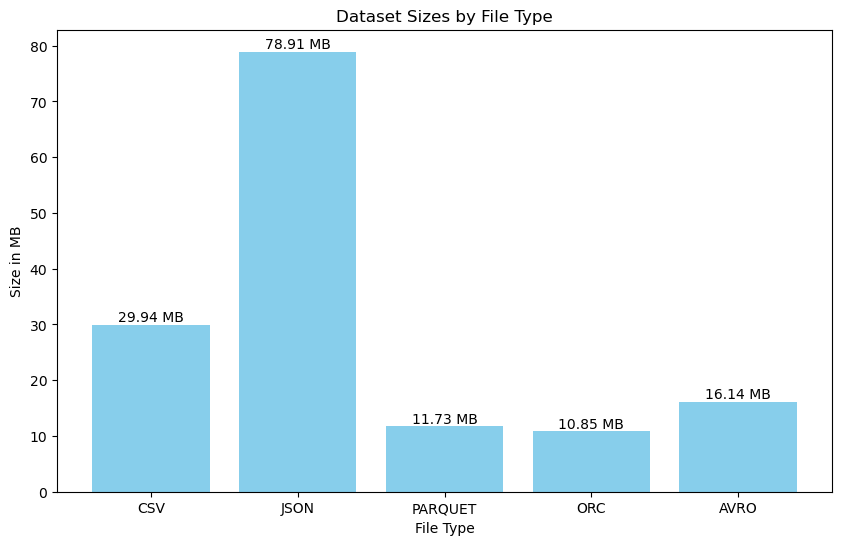

In [23]:
# Collect the data from the Spark DataFrame back to the driver
collected_data = dataset_sizes_df.collect()

# Prepare the data for plotting
file_types = [row['File_Type'] for row in collected_data]
sizes = [row['Size (MB)'] for row in collected_data]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(file_types, sizes, color='skyblue')
plt.xlabel('File Type')
plt.ylabel('Size in MB')
plt.title('Dataset Sizes by File Type')

# Display the MB number over each bar
for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{size:.2f} MB', 
             ha='center', va='bottom')

plt.show()

In [24]:
spark.stop()